Mounting Google drive and declaring tensorflow version


In [1]:
%tensorflow_version 2.3.x
import tensorflow as tf

from google.colab import drive
drive.mount('/content/drive')


`%tensorflow_version` only switches the major version: 1.x or 2.x.
You set: `2.3.x`. This will be interpreted as: `2.x`.


TensorFlow 2.x selected.
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Library imports

In [2]:
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.preprocessing.image import ImageDataGenerator


Variable and directory declarations

In [3]:
train = '/content/drive/My Drive/ham10000/training'
val = '/content/drive/My Drive/ham10000/validation'

IMG_HEIGHT = 224
IMG_WIDTH = 224
IMG_SIZE = (IMG_HEIGHT, IMG_WIDTH)
batch = 32
epoch = 15

Preprocessing Functions &
Rescaling the pixel values to be accepted by the model. View Documentation: https://www.tensorflow.org/api_docs/python/tf/keras/applications/MobileNetV2 

In [4]:
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input


train_batches = ImageDataGenerator(preprocessing_function = preprocess_input).flow_from_directory(train, class_mode='categorical', target_size=(IMG_HEIGHT, IMG_WIDTH,), batch_size = batch, shuffle = True)

val_batches = ImageDataGenerator(preprocessing_function = preprocess_input).flow_from_directory(val, class_mode='categorical', target_size=(IMG_HEIGHT, IMG_WIDTH,), batch_size = batch, shuffle = True)

Found 7000 images belonging to 7 classes.
Found 1400 images belonging to 7 classes.


Importing the mobilenet model from tensorflow

In [5]:
mobilenet_model = tf.keras.applications.MobileNetV2(include_top=False, input_shape=(IMG_HEIGHT, IMG_WIDTH, 3), weights='imagenet')

mobilenet_model.trainable = False
mobilenet_model.summary()

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 112, 112, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 112, 112, 32) 128         Conv1[0][0]                      
__________________________________________________________________________________________________
Conv1_relu (ReLU)               (None, 112, 112, 32) 0           bn_Conv1[0][0]                   
_______________________________________________________________________________



Adds a dropout, globalaveragepooling2d, dense, batchnormalization and finally a predictive dense layer

In [6]:
layer = mobilenet_model.output
layer = tf.keras.layers.Dropout(0.2)(layer)
layer = tf.keras.layers.GlobalAveragePooling2D()(layer)
layer = tf.keras.layers.Dense(128, activation='relu')(layer)
layer = tf.keras.layers.BatchNormalization()(layer)
prediction_layer = tf.keras.layers.Dense(7, activation='softmax')(layer)

Finalize Model

In [7]:
input = mobilenet_model.input
outputs = prediction_layer
model = tf.keras.Model(input, outputs)

In [8]:
base_learning_rate = 0.001
model.compile(optimizer=tf.keras.optimizers.Adam(lr=base_learning_rate),
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [9]:
model.summary()


Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 112, 112, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 112, 112, 32) 128         Conv1[0][0]                      
__________________________________________________________________________________________________
Conv1_relu (ReLU)               (None, 112, 112, 32) 0           bn_Conv1[0][0]                   
______________________________________________________________________________________________

Train model for 40 epochs

In [10]:
history = model.fit(
    train_batches,
    validation_data=val_batches,
    callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=3, verbose=1, mode='auto')],
    epochs=40
)


Epoch 1/40
219/219 [==============================] - 2152s 10s/step - loss: 1.3185 - accuracy: 0.5402 - val_loss: 0.8771 - val_accuracy: 0.6893
Epoch 2/40
219/219 [==============================] - 72s 329ms/step - loss: 0.6808 - accuracy: 0.7468 - val_loss: 0.7471 - val_accuracy: 0.7264
Epoch 3/40
219/219 [==============================] - 72s 328ms/step - loss: 0.5675 - accuracy: 0.7960 - val_loss: 0.7493 - val_accuracy: 0.7293
Epoch 4/40
219/219 [==============================] - 72s 328ms/step - loss: 0.4774 - accuracy: 0.8305 - val_loss: 0.8162 - val_accuracy: 0.7079
Epoch 5/40
219/219 [==============================] - 71s 326ms/step - loss: 0.4300 - accuracy: 0.8522 - val_loss: 0.7389 - val_accuracy: 0.7314
Epoch 6/40
219/219 [==============================] - 72s 328ms/step - loss: 0.4035 - accuracy: 0.8585 - val_loss: 0.7251 - val_accuracy: 0.7464
Epoch 7/40
219/219 [==============================] - 72s 327ms/step - loss: 0.3439 - accuracy: 0.8777 - val_loss: 0.7560 - val_ac

Plot Graph of loss and accuracy

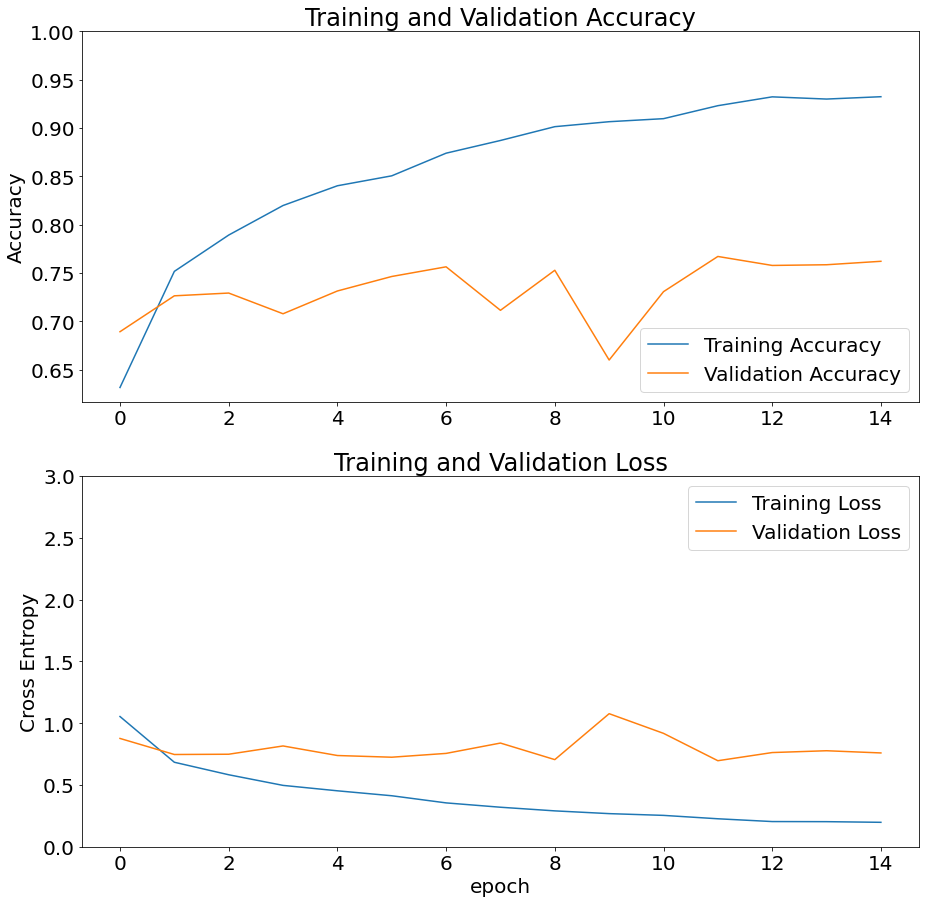

In [11]:
import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

font = {'family' : 'sans-serif',
        'size'   : 20}

plt.rc('font', **font)


plt.figure(figsize=(15, 15))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,3])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.savefig('graph.png', dpi=200)
plt.show()


Save model to google drive

In [12]:
tf.keras.models.save_model(model, '/content/drive/My Drive/protobufferv3')

INFO:tensorflow:Assets written to: /content/drive/My Drive/protobufferv3/assets


References:

*   https://www.tensorflow.org/tutorials/images/transfer_learning
*   https://github.com/Aaron-AB/Android-Application-for-Predicting-Pneumonia/blob/master/PneumoniaModel.ipynb

